The following code block imports some libraries we will start with.

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

warnings.simplefilter('ignore')

We will be working with a sample of the Iowa Liquor Sales data. The following code block reads the data, converts the date column from a string to a datetime, and prints the first 5 rows.

In [2]:
data = pd.read_csv('ils.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,vendor,category,liters_sold
0,2019-03-01,AMERICAN VINTAGE BEVERAGE,COCKTAILS /RTD,21.000
1,2019-03-01,BACARDI USA INC,100% AGAVE TEQUILA,7.500
2,2019-03-01,BACARDI USA INC,AGED DARK RUM,0.750
3,2019-03-01,BACARDI USA INC,COCKTAILS /RTD,26.250
4,2019-03-01,BACARDI USA INC,FLAVORED RUM,110.875


The following code block creates a `DataFrame` named `daily_sales` that aggregates the values in the `liters_sold` column, across all vendors and categories, by date. 

In [3]:
daily_sales = data.groupby(
    'date'
).agg(
    total_liters_sold=('liters_sold', 'sum')
)

The following code block plots the values in the `daily_sales` object.

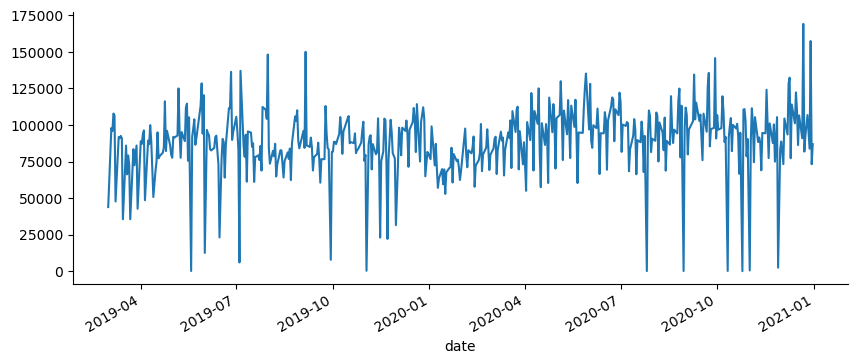

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

daily_sales.plot(
    y='total_liters_sold',
    ax=ax,
    legend=False,
)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

First, we used the data to answer the question:
> "**Was there a statistically significant increase in total liters sold after the start of the COVID shutdown (3/15/2020)? Provide a visualization that supports your claim.**"

We will need to filter the data for pre- and post-shutdown, so the following code block creates a column that determines whether or not a date is before the specified date or not.

In [5]:
daily_sales = daily_sales.reset_index()
daily_sales['post_shutdown'] = (daily_sales['date'] >= '3/15/2020').astype(int)

The following code block creates a period column, which is just a consecutive integer for each date. We will use this to generate regression plots. The first five rows of the modified `daily_sales` object is shown.

In [6]:
daily_sales = daily_sales.reset_index()
daily_sales = daily_sales.rename(columns={'index': 'period'})
daily_sales.head()

,period,date,total_liters_sold,post_shutdown
0,0,2019-03-01,43857.450,0
1,1,2019-03-04,97907.775,0
2,2,2019-03-05,95761.000,0
3,3,2019-03-06,107829.280,0
4,4,2019-03-07,106568.675,0


The following code block generates a figure that fits linear regression models for both the pre- and post-shutdown times. 

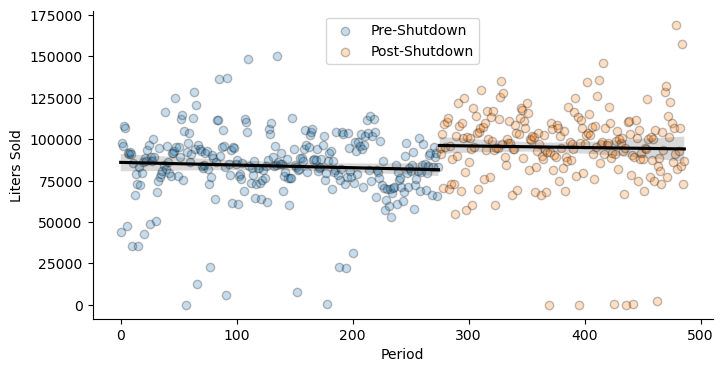

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.regplot(
    data=daily_sales[daily_sales['post_shutdown']==0],
    x='period',
    y='total_liters_sold',
    ax=ax,
    label='Pre-Shutdown',
    line_kws={'color': 'k'},
    scatter_kws={'alpha':0.25, 'edgecolor': 'k'},
)

sns.regplot(
    data=daily_sales[daily_sales['post_shutdown']==1],
    x='period',
    y='total_liters_sold',
    ax=ax,
    label='Post-Shutdown',
    line_kws={'color': 'k'},
    scatter_kws={'alpha':0.25, 'edgecolor': 'k'},
)


ax.spines[['right', 'top']].set_visible(False)
ax.legend()
ax.set_xlabel('Period')
ax.set_ylabel('Liters Sold')

plt.show()

The following code block generates a figure that plots 95% confidence intervals for the mean total liters sold each day for the pre- and post-shutdown times. The intervals do not overlap, thus, we can say that there was a statistically significant increase in the sales post-shutdown.

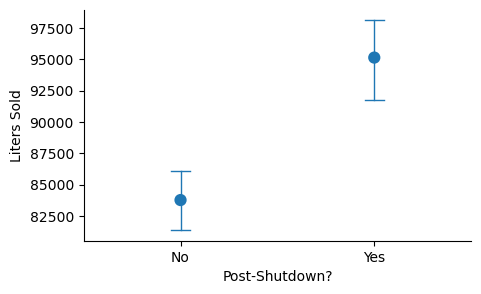

In [8]:
fig, ax = plt.subplots(1,1, figsize =(5, 3))

sns.pointplot(
    data=daily_sales,
    x='post_shutdown',
    y='total_liters_sold',
    join=False,
    errwidth=1.0,
    capsize=0.1,
)
ax.spines[['right','top']].set_visible(False)
ax.set_xlabel('Post-Shutdown?')
ax.set_ylabel('Liters Sold')
ax.set_xticklabels(['No', 'Yes'])

plt.show()

We will now focus our attention on fitting a distribution for the total liters sold during the period after the Covid shutdown. Before doing so, we want to take a look at the dates represented in the data. The following code block creates a `DataFrame` for the data after the shutdown (`post_data`), computes the earliest date in the dataset (`min_date`), the latest date in the dataset (`max_date`), and then prints the difference between the two.

In [9]:
post_data = daily_sales[daily_sales['post_shutdown'] == 1].copy()

min_date = post_data['date'].min()
max_date = post_data['date'].max()

print(f'{max_date - min_date = }')

max_date - min_date = Timedelta('290 days 00:00:00')


The output of the previous cell suggests that we should have roughly 291 days in our data (assuming the first date is included, which it is). Howvever, if we check the `shape` attribute for the `post_data` object, we see that many dates are missing.

In [10]:
post_data.shape

(212, 4)

The following code block generates a histogram for the `total_liters_sold` with the current data. We will compare to this distribution later.

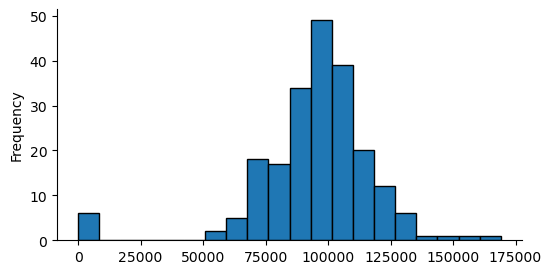

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

post_data['total_liters_sold'].plot(
    kind='hist',
    bins=20,
    edgecolor='k',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

The reason for the discrepancy is that the data is based on sales. If there are days with no cells, there would be no corresponding entry in the dataset. In class, I walked through how this can be remedied by reindexing the data to include all dates between the minimum and maximum date cmputed earlier and then filling in the sales values with 0. This is done in the following code block.

In [12]:
post_data = post_data.set_index('date')
date_range = pd.date_range(
    start=post_data.index.min(),
    end=post_data.index.max(),
)

post_data = post_data.reindex(date_range)
post_data['total_liters_sold'] = post_data['total_liters_sold'].fillna(0)
post_data['post_shutdown'] = post_data['post_shutdown'].fillna(1)

If we check the `shape` now, we see the data has 291 rows.

In [13]:
post_data.shape

(291, 3)

The following code block generates a histogram for the `total_liters_sold` with the missing entries corrected. If you compare this histogram to the one generated earlier, you will see they are very different. Thus, if we had fit the distribution based on the previous data, we would have made a significant mistake.

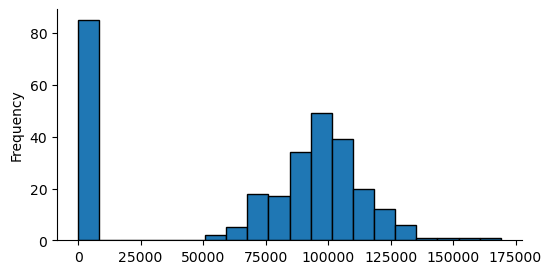

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

post_data['total_liters_sold'].plot(
    kind='hist',
    bins=20,
    edgecolor='k',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

We will break the task of distribution fitting into two cases: 1) days where demand is greater than 2500 (Demand > 2500) and 2) days where demand is less than or equal to 2500 (Demand $\leq$ 2500).

#### Case 1: Demand > 2500

The following code block creates a `DataFrame` for the case 1 analysis.

In [15]:
case1_data = post_data[post_data['total_liters_sold'] > 2500].copy()

The following code block imports `numpy` and the `scipy.stats` libraries, which we will use for the analysis.

In [16]:
import numpy as np
import scipy.stats as st

The following code block creates a `numpy` array of the `total_liters_sold` values for the case 1 data.

In [17]:
demand_values = case1_data['total_liters_sold'].values
print(f'{len(demand_values) = }')

len(demand_values) = 206


The following code block fits the fitted distribution and the data values for seven specific distributional forms:
- Normal (`st.norm`)
- Lognormal (`st.lognorm`)
- Uniform (`st.uniform`)
- Beta (`st.beta`)
- Gamma (`st.gamma`)
- Triangular (`st.triang`)
- Exponential (`st.expon`)

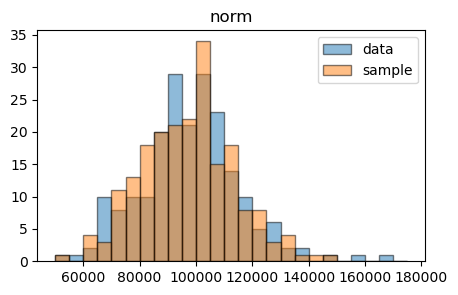

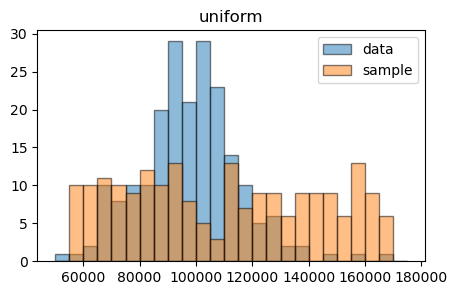

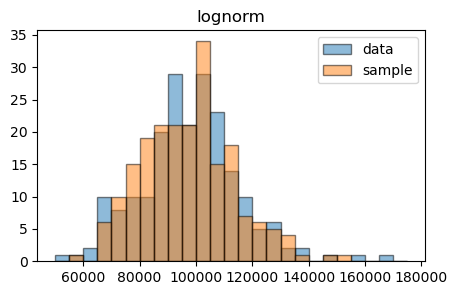

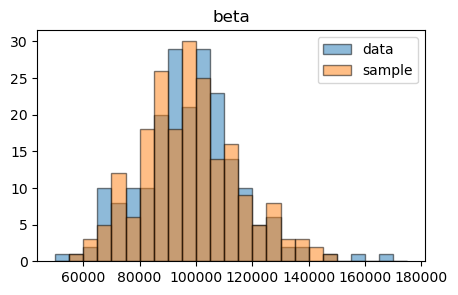

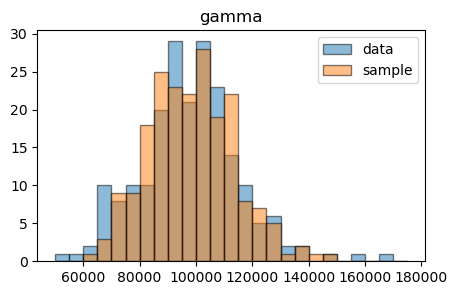

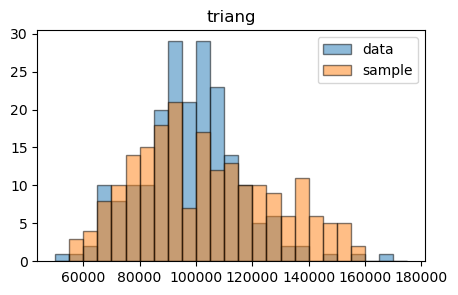

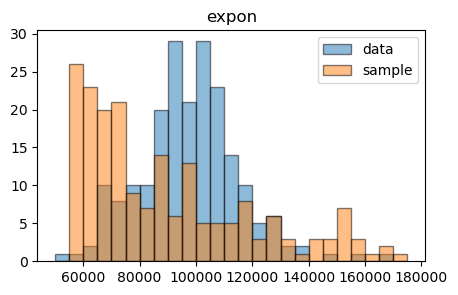

In [18]:
distribution_list = [
    st.norm,
    st.uniform,
    st.lognorm,
    st.beta,
    st.gamma,
    st.triang,
    st.expon,
]

for current_dist in distribution_list:

    # get parameters for best fit of current type
    dist_params = current_dist.fit(demand_values)
    
    # create fitted object using best parameters
    fit_dist = current_dist(*dist_params)
    
    # generate random values
    rvs = fit_dist.rvs(206, random_state=42)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))

    ax.hist(
        demand_values,
        bins=range(50000, 180000, 5000),
        label='data',
        edgecolor='k',
        alpha=0.5,
    )

    ax.hist(
        rvs,
        bins=range(50000, 180000, 5000),
        label='sample',
        edgecolor='k',
        alpha=0.5,
    )
    ax.set_title(current_dist.name)
    ax.legend()
    plt.show()

Druing class, we went through the steps to compare two distributions using the `np.histogram` function. At a high level, we use the function to generate histogram bins and counts for two data samples, making sure that the exact same bins are used when constructing both histograms. We then compute the difference in counts for each bins, i.e., the *error*, and use these error values to compute the **Residual Sum of Squares (RSS)**. For more information on the residual sum of squares, see https://en.wikipedia.org/wiki/Residual_sum_of_squares. The final code we completed in class is shown below.

In [19]:
distribution_list = [
    st.norm,
    st.uniform,
    st.lognorm,
    st.beta,
    st.gamma,
    st.triang,
    st.expon,
]

num_bins = 30

samples_to_generate = len(demand_values)
for current_dist in distribution_list:

    best_params = current_dist.fit(demand_values)
    fit_dist = current_dist(*best_params)
    rvs = fit_dist.rvs(samples_to_generate, random_state=42)

    # Get lowest value in data or randomly generated sample
    lower_bound = min(demand_values.min(), rvs.min())

    # Get highest value in data or randomly generated sample
    upper_bound = max(demand_values.max(), rvs.max())

    # Generate bin edges based on lower bound, upper bound, and number of bins.
    # Note that the "+1" is needed becuase we need n+1 bin edges to
    # generate n bins.
    bins = np.linspace(lower_bound, upper_bound, num=num_bins + 1)

    # Get counts and bins for data
    data_counts, data_bins = np.histogram(demand_values, bins=bins)

    # Get counts and bins for sample
    sample_counts, sample_bins = np.histogram(rvs, bins=bins)

    # Compute residual sum of squares
    RSS = np.sum((data_counts - sample_counts)**2)
    print(current_dist.name)
    print(f'{RSS = }')
    print('-'*40)

norm
RSS = 352
----------------------------------------
uniform
RSS = 1756
----------------------------------------
lognorm
RSS = 314
----------------------------------------
beta
RSS = 250
----------------------------------------
gamma
RSS = 254
----------------------------------------
triang
RSS = 814
----------------------------------------
expon
RSS = 3508
----------------------------------------


#### Case 2: Demand $\leq$ 2500

The following code block replicates the entire procedure for the case where demand is less than or equal to 2500.

In [20]:
case2_data = post_data[post_data['total_liters_sold'] <= 2500].copy()
demand_values = case2_data['total_liters_sold'].values
print(f'{len(demand_values) = }')

distribution_list = [
    st.norm,
    st.uniform,
    st.lognorm,
    st.beta,
    st.gamma,
    st.triang,
    st.expon,
]

num_bins = 30

samples_to_generate = len(demand_values)
for current_dist in distribution_list:

    best_params = current_dist.fit(demand_values)
    fit_dist = current_dist(*best_params)
    rvs = fit_dist.rvs(samples_to_generate, random_state=42)

    # Get lowest value in data or randomly generated sample
    lower_bound = min(demand_values.min(), rvs.min())

    # Get highest value in data or randomly generated sample
    upper_bound = max(demand_values.max(), rvs.max())

    # Generate bin edges based on lower bound, upper bound, and number of bins.
    # Note that the "+1" is needed becuase we need n+1 bin edges to
    # generate n bins.
    bins = np.linspace(lower_bound, upper_bound, num=num_bins + 1)

    # Get counts and bins for data
    data_counts, data_bins = np.histogram(demand_values, bins=bins)

    # Get counts and bins for sample
    sample_counts, sample_bins = np.histogram(rvs, bins=bins)

    # Compute residual sum of squares
    RSS = np.sum((data_counts - sample_counts)**2)
    print(current_dist.name)
    print(f'{RSS = }')
    print('-'*40)

len(demand_values) = 85
norm
RSS = 4964
----------------------------------------
uniform
RSS = 6542
----------------------------------------
lognorm
RSS = 20
----------------------------------------
beta
RSS = 20
----------------------------------------
gamma
RSS = 122
----------------------------------------
triang
RSS = 5790
----------------------------------------
expon
RSS = 102
----------------------------------------


The following code block uses two distributions that we found to fit the data for each case very well, along with a set of binomial random variables to capture the likelihood of any day falling into either case, to generate a random sample of values that mimics the historical sales. With such a process for simulating demand values developed, we can use this to approximate the impact of changes, e.g., different inventory management strategies, using a virtual simulation before we actually implement the changes in physical stores.

In [21]:
np.random.seed(42)

case1_data = post_data[post_data['total_liters_sold'] > 2500].copy()
case1_demand_values = case1_data['total_liters_sold'].values
case_1_params = st.lognorm.fit(case1_demand_values)
case_1_dist = st.lognorm(*case_1_params)

case2_data = post_data[post_data['total_liters_sold'] <= 2500].copy()
case2_demand_values = case2_data['total_liters_sold'].values
case_2_params = st.lognorm.fit(case2_demand_values)
case_2_dist = st.lognorm(*case_2_params)

post_data['case1'] = (post_data['total_liters_sold'] > 2500).astype(int)
success_probability = post_data['case1'].mean()

case_1_array = np.random.binomial(n=1, p=success_probability, size=len(post_data))

random_sample = []
for case_1_value in case_1_array:
    if case_1_value == 1:
        random_sample.append(case_1_dist.rvs())
    else:
        random_sample.append(case_2_dist.rvs())

The following code block uses histograms to plot the generated sample along with the original data. As you can see, the generated sample does a good job of approximating the data.

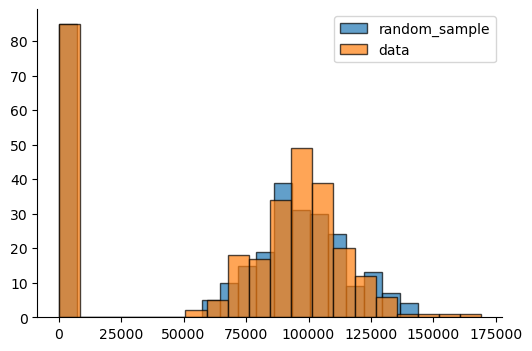

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(
    random_sample, 
    bins=20,
    edgecolor='k',
    label='random_sample',
    alpha=0.7,
)

ax.hist(
    post_data['total_liters_sold'].values, 
    bins=20,
    edgecolor='k',
    label='data',
    alpha=0.7,
)

ax.legend()
ax.spines[['right', 'top']].set_visible(False)

plt.show()